In [1]:
import pandas as pd
import requests
import io

jh_covid19_base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
jh_covid19_datasets = ['time_series_covid19_confirmed_global.csv', 'time_series_covid19_deaths_global.csv', 'time_series_covid19_confirmed_US.csv', 'time_series_covid19_deaths_US.csv']

def df_between_dates(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    if 'date' not in list(df.columns):
        return df
    date_range = (df['date'] > start_date) & (df['date'] <= end_date)
    return df[date_range]

def tweak_cigar(df: pd.DataFrame)->pd.DataFrame:
    return df.rename(columns={
        'Country':'country',
        'Cigarette Consumption':'consumption'
    }).astype({
        'country': 'category',
        'consumption': 'float16'
    }).sort_values(
        'consumption', ascending=False
    ).dropna()

def tweak_covid19_dataset(df: pd.DataFrame, name: str) -> pd.DataFrame:
    df = df.drop(
        columns=['Province/State', 'Lat', 'Long']
    ).rename(columns={
        'Country/Region':'country'
    })
    melted = pd.melt(
        df,
        id_vars=['country'],
        value_vars=df.columns[1:], 
        var_name='date',
        value_name=f'total_{name}'
    ).groupby(
        ['country','date'], as_index=False
    ).agg({
        f'total_{name}': 'sum', 'country': 'first'
    }).fillna(
        0
    )
    non_cum = melted.assign(
        date = melted.date.astype('datetime64'),
    ).sort_values(
        by=['country', 'date']
    ).assign(
        non_cumulative = lambda df_: df_[f'total_{name}'].diff()
    ).rename(columns={
        'non_cumulative': name
    }).dropna()
    non_cum[non_cum[name] < 0] = 0
    return non_cum

def merge_dfs(df_a: pd.DataFrame, df_b: pd.DataFrame, _on: list, _how: str='inner') -> pd.DataFrame:
    return pd.merge(df_a, df_b, how=_how, on=_on)

def get_csv(url) -> pd.DataFrame:
    headers = {'User-Agent': 'Mozilla/5.0'}
    content = io.StringIO(requests.get(url, headers=headers).content.decode('utf-8'))
    return pd.read_csv(content)
    
confirmed_global, deaths_global, confirmed_US, deaths_US = (
    get_csv(f'{jh_covid19_base_url}/{data_set}') for data_set in jh_covid19_datasets
)

confirmed_global = tweak_covid19_dataset(confirmed_global, 'cases')
deaths_global = tweak_covid19_dataset(deaths_global, 'deaths')
avg_daily_cigar_consumption = tweak_cigar(get_csv("https://tobaccoatlas.org/wp-content/uploads/2022/05/data-z9rR9.csv"))
weekly_excercise_hours_mean = pd.read_csv('./data/ipsos_global_views_exercise.csv')
median_age_by_country = pd.read_csv('./data/median_age_country.csv')
covid_stats = pd.merge(
    confirmed_global, deaths_global, how='inner', on=['date', 'country']
).astype({
    'deaths':'int64',
    'cases':'int64',
    'country':'category'
}).assign(
    mortality = lambda _df: _df.deaths / _df.cases
).pipe(
    merge_dfs, df_b=avg_daily_cigar_consumption, _on=['country']
).pipe(
    merge_dfs, df_b=weekly_excercise_hours_mean, _on=['country']
).pipe(
    merge_dfs, df_b=median_age_by_country, _on=['country']
).fillna(0)

In [2]:
covid_stats_monthly = covid_stats.groupby([
    covid_stats.date.dt.year.rename('year'),
    covid_stats.date.dt.month.rename('month'),
    'country'
], as_index=True).agg({
    'cases':'sum',
    'deaths':'sum',
    'consumption':'first',
    'mortality':'mean',
    'weekly_excercise_hours_mean':'first',
    'country':'first',
    'median_age':'last'
})
#COVID VACCINE CAME OUT ON AUG 2021
covid_stats_monthly.loc[2021].sort_values(by='deaths', ascending=False)

cases   deaths  consumption  mortality  \
month country                                                 
5     India      657735475  8763066       90.375   0.014511   
4     Brazil     139554976  6014616      330.000   0.043102   
6     India      163271070  4932172       90.375   0.030053   
3     Brazil     160986973  4888007      330.000   0.030186   
5     Brazil     137443232  4286122      330.000   0.031017   
...                    ...      ...          ...        ...   
      Australia      22411        0      668.500   0.000000   
3     Australia      25112        0      668.500   0.000000   
11    China         163666        0     1971.000   0.000000   
1     Australia      28689        0      668.500   0.000000   
2     Australia      11680        0      668.500   0.000000   

                 weekly_excercise_hours_mean    country  median_age  
month country                                                        
5     India                              7.9      India     27.9028  
4     Brazil                             3.0     Brazil     33.2087  
6     India                              7.9      India     27.9028  
3     Brazil                             3.0     Brazil     33.2087  
5     Brazil                             3.0     Brazil     33.2087  
...                                      ...        ...         ...  
      Australia                          6.2  Australia     37.2382  
3     Australia                          6.2  Australia     37.2382  
11    China                              6.4      China     38.4667  
1     Australia                          6.2  Australia     37.2382  
2     Australia                          6.2  Australia     37.2382  

[288 rows x 7 columns]

In [3]:
covid_stats_country = covid_stats.groupby([
    covid_stats.date.dt.year.rename('year'),
    'country'
], as_index=True).agg({
    'cases':'sum',
    'deaths':'sum',
    'consumption':'first',
    'mortality':'mean',
    'weekly_excercise_hours_mean':'first',
    'country':'first',
    'median_age':'last'
})
covid_stats_country_2020 = covid_stats_country.loc[2020].sort_values(by='mortality', ascending=False)
covid_stats_country_2020

,cases,deaths,consumption,mortality,weekly_excercise_hours_mean,country,median_age
country,,,,,,,
Hungary,23543522,696201,801.500,0.090560,8.8,Hungary,42.2639
France,199702085,4492931,793.500,0.078003,3.7,France,41.7954
Mexico,104104862,9183911,601.000,0.075164,4.4,Mexico,29.3867
Italy,153791801,5412439,1266.000,0.072173,3.6,Italy,47.2653
Belgium,47151649,1434085,1284.000,0.058832,6.9,Belgium,41.0417
China,7449139,347845,1971.000,0.048776,6.4,China,38.4667
Australia,2073638,66430,668.500,0.043478,6.2,Australia,37.2382
Netherlands,59568730,843004,696.500,0.040460,12.8,Netherlands,41.8288
Japan,17209531,254916,1133.000,0.039896,3.3,Japan,48.7449


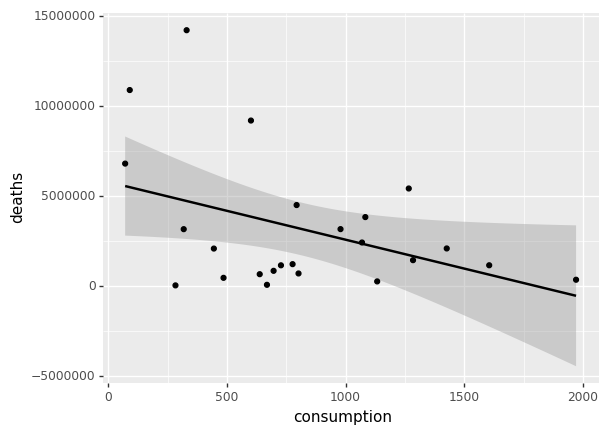

<ggplot: (716642838)>

In [4]:
from plotnine import ggplot, aes, geom_line, geom_point, geom_smooth, stat_summary, stat_smooth, labs

(
    ggplot(covid_stats_country_2020)
    + aes(x="consumption", y="deaths", label = 'country')
    + geom_smooth(method='lm')
    + geom_point()
)

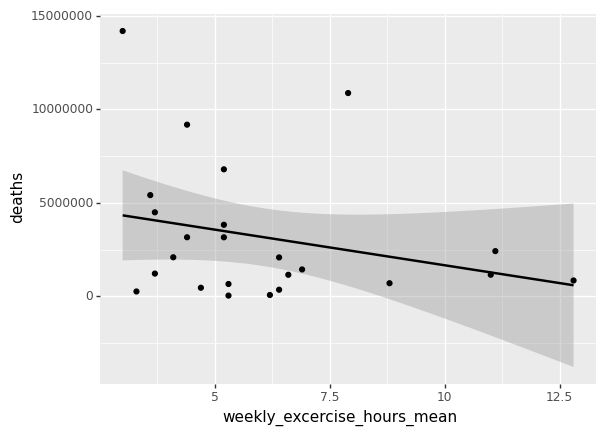

<ggplot: (716759321)>

In [5]:
(
    ggplot(covid_stats_country_2020)
    + aes(x="weekly_excercise_hours_mean", y="deaths", label = 'country')
    + geom_smooth(method='lm')
    + geom_point()
)

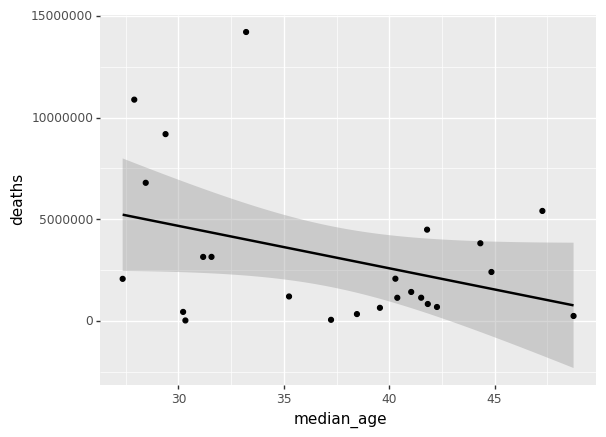

<ggplot: (716762564)>

In [6]:
(
    ggplot(covid_stats_country_2020)
    + aes(x="median_age", y="deaths", label = 'country')
    + geom_smooth(method='lm')
    + geom_point()
)